In [1]:
import tensorflow as tf### models
import numpy as np### math computations
import matplotlib.pyplot as plt### plotting bar chart
import sklearn### machine learning library
import cv2## image processing
from sklearn.metrics import confusion_matrix, roc_curve### metrics
import seaborn as sns### visualizations
import datetime
import pathlib
import io
import os
import re
import string
import time
from numpy import random
import gensim.downloader as api
from PIL import Image
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import (Dense,Flatten,SimpleRNN,InputLayer,Conv1D,Bidirectional,GRU,LSTM,BatchNormalization,Dropout,Input, Embedding,TextVectorization)
from tensorflow.keras.losses import BinaryCrossentropy,CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy,TopKCategoricalAccuracy, CategoricalAccuracy, SparseCategoricalAccuracy
from tensorflow.keras.optimizers import Adam
from google.colab import drive
from google.colab import files
from tensorboard.plugins import projector

In [2]:
BATCH_SIZE=64

# Data Preparation

In [4]:
train_ds,val_ds,test_ds=tfds.load('imdb_reviews', split=['train', 'test[:50%]', 'test[50%:]'],as_supervised=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.KKDK7Q_1.0.0/imdb_reviews-train.tfrecor…

Generating test examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.KKDK7Q_1.0.0/imdb_reviews-test.tfrecord…

Generating unsupervised examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.KKDK7Q_1.0.0/imdb_reviews-unsupervised.…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [5]:
train_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [6]:
for review,label in val_ds.take(2):
  print(review)
  print(label)

tf.Tensor(b"There are films that make careers. For George Romero, it was NIGHT OF THE LIVING DEAD; for Kevin Smith, CLERKS; for Robert Rodriguez, EL MARIACHI. Add to that list Onur Tukel's absolutely amazing DING-A-LING-LESS. Flawless film-making, and as assured and as professional as any of the aforementioned movies. I haven't laughed this hard since I saw THE FULL MONTY. (And, even then, I don't think I laughed quite this hard... So to speak.) Tukel's talent is considerable: DING-A-LING-LESS is so chock full of double entendres that one would have to sit down with a copy of this script and do a line-by-line examination of it to fully appreciate the, uh, breadth and width of it. Every shot is beautifully composed (a clear sign of a sure-handed director), and the performances all around are solid (there's none of the over-the-top scenery chewing one might've expected from a film like this). DING-A-LING-LESS is a film whose time has come.", shape=(), dtype=string)
tf.Tensor(1, shape=(),

In [7]:
def standardization(input_data):
    '''
    Input: raw reviews
    output: standardized reviews
    '''
    lowercase=tf.strings.lower(input_data)
    no_tag=tf.strings.regex_replace(lowercase,"<[^>]+>","")
    output=tf.strings.regex_replace(no_tag,"[%s]"%re.escape(string.punctuation),"")

    return output

In [8]:
standardization(tf.constant("<u>In the movie?, </u>man called Tévèz, went to a friend’s pl**ce and they had a tensed discussion. I don’t love this movie! would you?<br> <br /><br />T"))

<tf.Tensor: shape=(), dtype=string, numpy=b'in the movie man called t\xc3\xa9v\xc3\xa8z went to a friend\xe2\x80\x99s plce and they had a tensed discussion i don\xe2\x80\x99t love this movie would you t'>

In [9]:
VOCAB_SIZE=10000
SEQUENCE_LENGTH=250
EMBEDDING_DIM=300

In [10]:
vectorize_layer=TextVectorization(
    standardize=standardization,
    max_tokens=VOCAB_SIZE,
    output_mode='int',
    output_sequence_length=SEQUENCE_LENGTH
)

In [11]:
# lengths=[]
# words=[]

# for review,label in train_ds.take(100):
#   # for word in tf.strings.split(review, sep=" "):
#   #   if word in words:
#   #     pass
#   #   else:
#   #     words.append(word)
#   lengths.append(len(tf.strings.split(review, sep=" ")))

In [12]:
training_data=train_ds.map(lambda x,y:x)### input x and y and outputx
vectorize_layer.adapt(training_data)#### adapt the vectorize_layer to the training data

In [13]:
len(vectorize_layer.get_vocabulary())

10000

In [14]:
def vectorizer(review,label):
    return vectorize_layer(review),label

In [15]:
train_dataset=train_ds.map(vectorizer)
val_dataset=val_ds.map(vectorizer)

In [16]:
vectorize_layer.get_vocabulary()[411]

'absolutely'

In [17]:
for review,label in train_dataset.take(1):
  print(review)
  print(label)

tf.Tensor(
[  10   13   33  411  384   17   89   26    1    8   32 1337 3521   40
  491    1  192   22   84  149   18   10  215  317   26   64  239  212
    8  484   54   64   84  111   95   21 5502   10   91  637  737   10
   17    7   33  393 9554  169 2443  406    2   87 1205  135   65  142
   52    2    1 7408   65  245   64 2832   16    1 2851    1    1 1415
 4969    3   39    1 1567   15 3521   13  156   18    4 1205  881 7874
    8    4   17   12   13 4037    5   98  145 1234   11  236  696   12
   48   22   91   37   10 7285  149   37 1337    1   49  396   11   95
 1148  841  140    9    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0 

In [18]:
train_dataset=train_dataset.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset=val_dataset.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

# Modeling

## SimpleRNN

In [19]:
inputs=np.random.random([32, 10, 8]).astype(np.float32)
simple_rnn=tf.keras.layers.SimpleRNN(25)
output=simple_rnn(inputs)
print(output.shape)

(32, 25)


In [20]:
EMBEDDING_DIM=64
model=tf.keras.models.Sequential([
    Input(shape=(SEQUENCE_LENGTH,)),
    Embedding(VOCAB_SIZE,EMBEDDING_DIM),
    SimpleRNN(32),
    Dense(1,activation='sigmoid'),
])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 250, 64)             │         640,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_1 (SimpleRNN)             │ (None, 32)                  │           3,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 643,137 (2.45 MB)

 Trainable params: 643,137 (2.45 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
checkpoint_filepath = '/content/drive/MyDrive/nlp/sentiment_analysis/rnn.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

ValueError: The filepath provided must end in `.keras` (Keras model format). Received: filepath=/content/drive/MyDrive/nlp/sentiment_analysis/rnn.h5

In [27]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [26]:
history=model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=50,
    verbose =1,
    callbacks=[])

Epoch 1/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.5746 - loss: 0.6703 - val_accuracy: 0.6785 - val_loss: 0.6347
Epoch 2/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.6791 - loss: 0.6196 - val_accuracy: 0.6960 - val_loss: 0.6067
Epoch 3/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 29s 62ms/step - accuracy: 0.7934 - loss: 0.5085 - val_accuracy: 0.7826 - val_loss: 0.5198
Epoch 4/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 35s 48ms/step - accuracy: 0.8579 - loss: 0.4067 - val_accuracy: 0.7804 - val_loss: 0.5228
Epoch 5/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 20s 47ms/step - accuracy: 0.8936 - loss: 0.3273 - val_accuracy: 0.7956 - val_loss: 0.5007
Epoch 6/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 19s 43ms/step - accuracy: 0.9084 - loss: 0.2844 - val_accuracy: 0.8137 - val_loss: 0.4541
Epoch 7/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 18s 46ms/step - accuracy: 0.9111 - loss: 0.2725 - val_accuracy: 0.8287 - val_loss: 0.4440
Epoch 8/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 19s 42ms/step - accuracy: 0.9184 - loss: 0.2553 - 

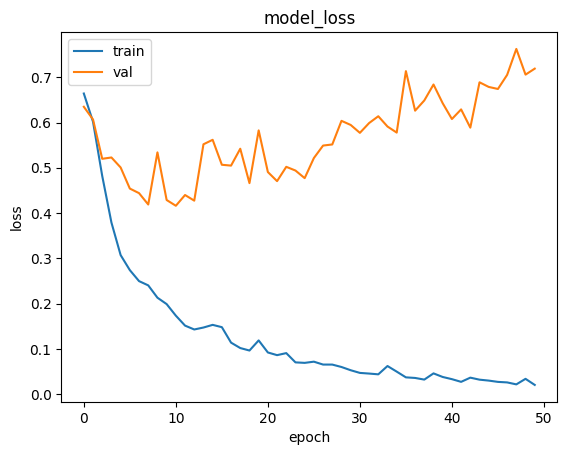

In [28]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

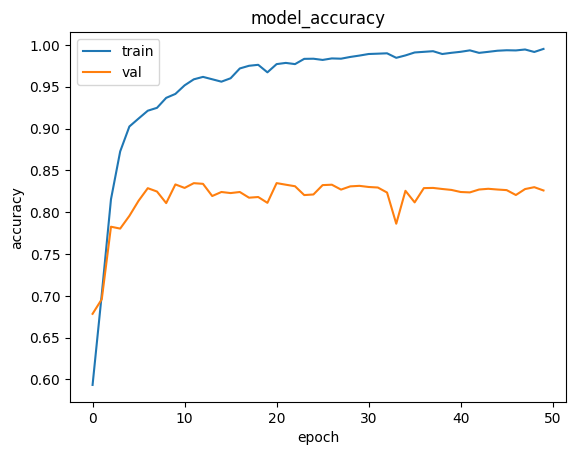

In [29]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model_accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Evaluation

In [30]:
test_dataset=test_ds.map(vectorizer)
test_dataset=test_dataset.batch(BATCH_SIZE)
model.evaluate(train_dataset)

391/391 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - accuracy: 0.9935 - loss: 0.0273


[0.026628946885466576, 0.9933599829673767]

In [31]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# Get predictions and true labels from the validation set
y_true = []
y_pred = []

for x_batch, y_batch in val_dataset:
    y_true.extend(y_batch.numpy())  # Ground truth labels
    y_pred_batch = model.predict(x_batch)  # Model predictions
    y_pred.extend(np.argmax(y_pred_batch, axis=-1))  # Predicted labels (argmax for multi-class)

# Convert to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Calculate precision, recall, and F1 score
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")



2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


AUC Score: 0.8726279907239016


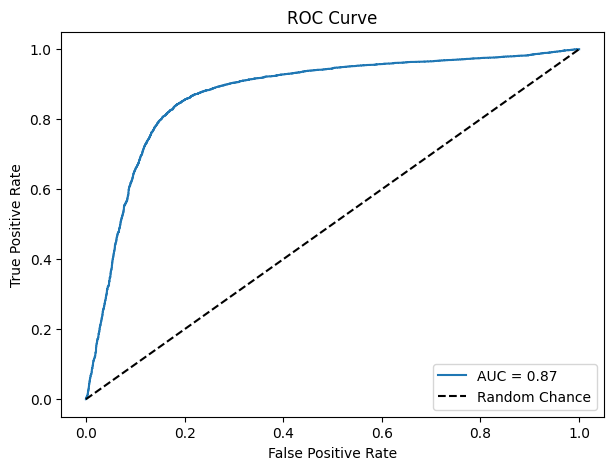

In [33]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Assuming binary classification
y_true_binarized = label_binarize(y_true, classes=[0, 1])[:, 0]
y_pred_probs = np.squeeze(y_pred_probs)  # Convert (num_samples, 1) -> (num_samples,)

auc_score = roc_auc_score(y_true_binarized, y_pred_probs)
fpr, tpr, _ = roc_curve(y_true_binarized, y_pred_probs)

print(f"AUC Score: {auc_score}")

# Plot ROC Curve
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.2f}")
plt.plot([0, 1], [0, 1], 'k--', label="Random Chance")
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()


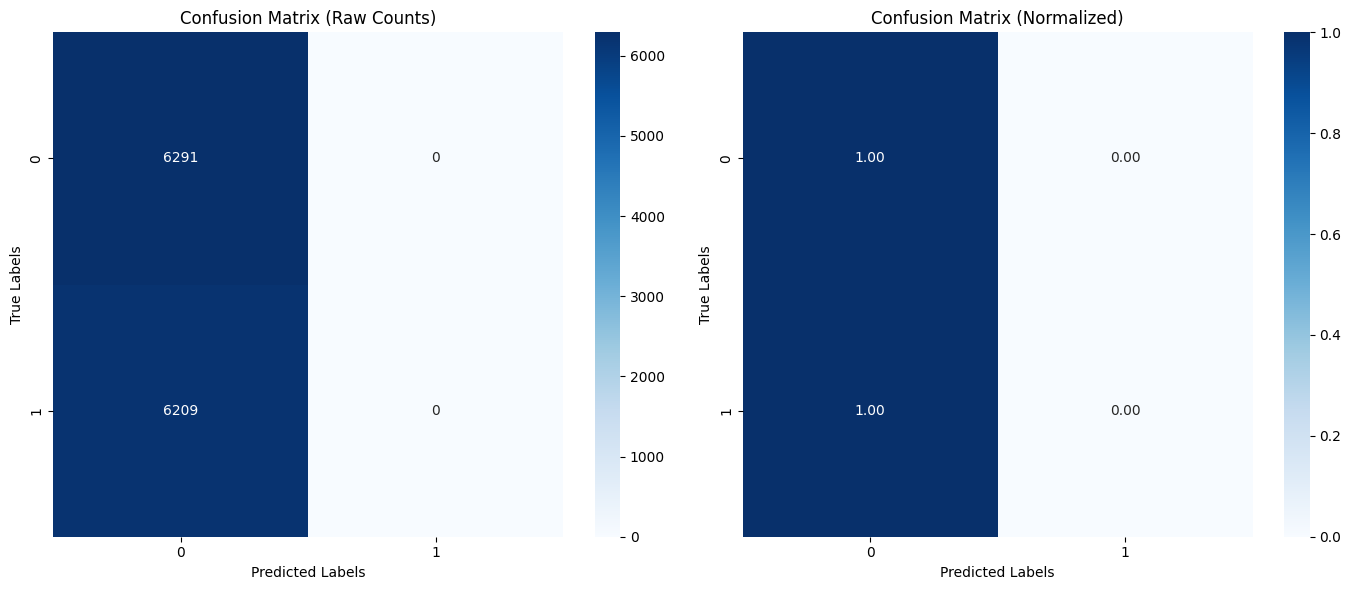

In [34]:
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Normalized confusion matrix
normalized_conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# Plot raw confusion matrix using Seaborn
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(n_classes), yticklabels=range(n_classes))
plt.title("Confusion Matrix (Raw Counts)")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")

# Plot normalized confusion matrix using Seaborn
plt.subplot(1, 2, 2)
sns.heatmap(normalized_conf_matrix, annot=True, fmt='.2f', cmap='Blues', xticklabels=range(n_classes), yticklabels=range(n_classes))
plt.title("Confusion Matrix (Normalized)")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")

plt.tight_layout()
plt.show()

# # Alternatively, display normalized confusion matrix using sklearn
# disp = ConfusionMatrixDisplay(normalized_conf_matrix, display_labels=range(n_classes))
# disp.plot(cmap='Blues', values_format='.2f')
# plt.title("Normalized Confusion Matrix")
# plt.show()


## LSTM (MultiLayer and Bidirectional)

In [35]:
EMBEDDING_DIM=64
model=tf.keras.models.Sequential([
    Input(shape=(SEQUENCE_LENGTH,)),
    Embedding(VOCAB_SIZE,EMBEDDING_DIM),

    Bidirectional(LSTM(64,return_sequences=True)),
    Bidirectional(LSTM(32)),

    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1,activation='sigmoid'),
])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, 250, 64)             │         640,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 250, 128)            │          66,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 64)                  │          41,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 751,489 (2.87 MB)

 Trainable params: 751,489 (2.87 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
checkpoint_filepath = '/content/drive/MyDrive/nlp/sentiment_analysis/lstm.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [36]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [41]:
history=model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=25,
    callbacks=[])

Epoch 1/25
391/391 ━━━━━━━━━━━━━━━━━━━━ 28s 56ms/step - accuracy: 0.5209 - loss: 0.6911 - val_accuracy: 0.7604 - val_loss: 0.5200
Epoch 2/25
391/391 ━━━━━━━━━━━━━━━━━━━━ 22s 55ms/step - accuracy: 0.8251 - loss: 0.4108 - val_accuracy: 0.8610 - val_loss: 0.3326
Epoch 3/25
391/391 ━━━━━━━━━━━━━━━━━━━━ 23s 59ms/step - accuracy: 0.9011 - loss: 0.2643 - val_accuracy: 0.8609 - val_loss: 0.3538
Epoch 4/25
391/391 ━━━━━━━━━━━━━━━━━━━━ 45s 69ms/step - accuracy: 0.9281 - loss: 0.2129 - val_accuracy: 0.8569 - val_loss: 0.3952
Epoch 5/25
391/391 ━━━━━━━━━━━━━━━━━━━━ 34s 52ms/step - accuracy: 0.9379 - loss: 0.1903 - val_accuracy: 0.8522 - val_loss: 0.4312
Epoch 6/25
391/391 ━━━━━━━━━━━━━━━━━━━━ 22s 56ms/step - accuracy: 0.9420 - loss: 0.1735 - val_accuracy: 0.8478 - val_loss: 0.4306
Epoch 7/25
391/391 ━━━━━━━━━━━━━━━━━━━━ 41s 55ms/step - accuracy: 0.9373 - loss: 0.1742 - val_accuracy: 0.8460 - val_loss: 0.4235
Epoch 8/25
391/391 ━━━━━━━━━━━━━━━━━━━━ 40s 52ms/step - accuracy: 0.9560 - loss: 0.1364 - 

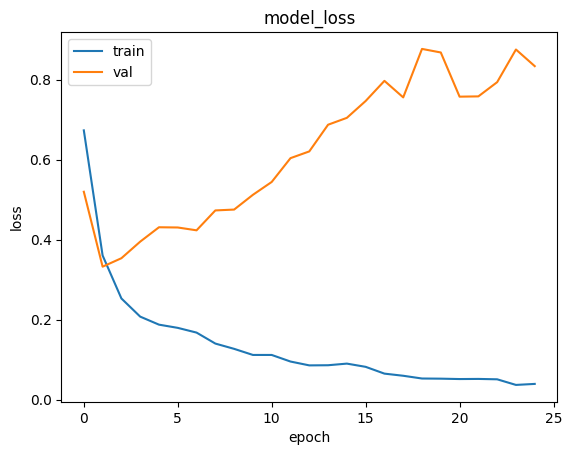

In [42]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

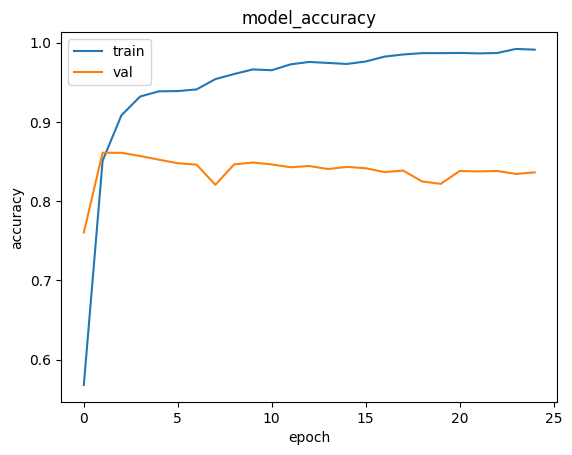

In [43]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model_accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Evaluation

In [44]:
test_dataset=test_ds.map(vectorizer)
test_dataset=test_dataset.batch(BATCH_SIZE)
model.evaluate(test_dataset)

196/196 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.8349 - loss: 0.8349


[0.8221409916877747, 0.8379999995231628]

In [45]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# Get predictions and true labels from the validation set
y_true = []
y_pred = []

for x_batch, y_batch in val_dataset:
    y_true.extend(y_batch.numpy())  # Ground truth labels
    y_pred_batch = model.predict(x_batch)  # Model predictions
    y_pred.extend(np.argmax(y_pred_batch, axis=-1))  # Predicted labels (argmax for multi-class)

# Convert to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Calculate precision, recall, and F1 score
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")



2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


AUC Score: 0.8726279907239016


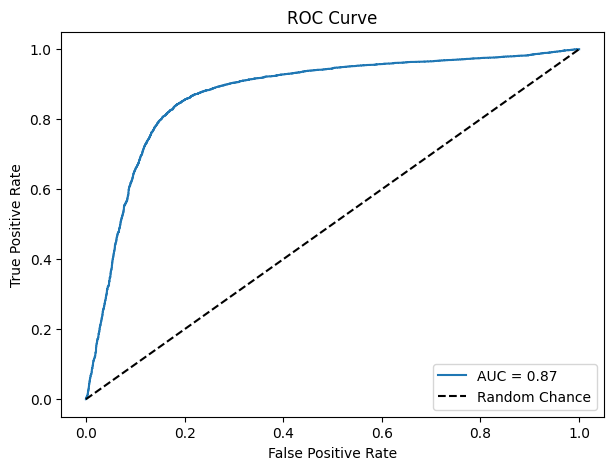

In [46]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Assuming binary classification
y_true_binarized = label_binarize(y_true, classes=[0, 1])[:, 0]
y_pred_probs = np.squeeze(y_pred_probs)  # Convert (num_samples, 1) -> (num_samples,)

auc_score = roc_auc_score(y_true_binarized, y_pred_probs)
fpr, tpr, _ = roc_curve(y_true_binarized, y_pred_probs)

print(f"AUC Score: {auc_score}")

# Plot ROC Curve
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.2f}")
plt.plot([0, 1], [0, 1], 'k--', label="Random Chance")
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()


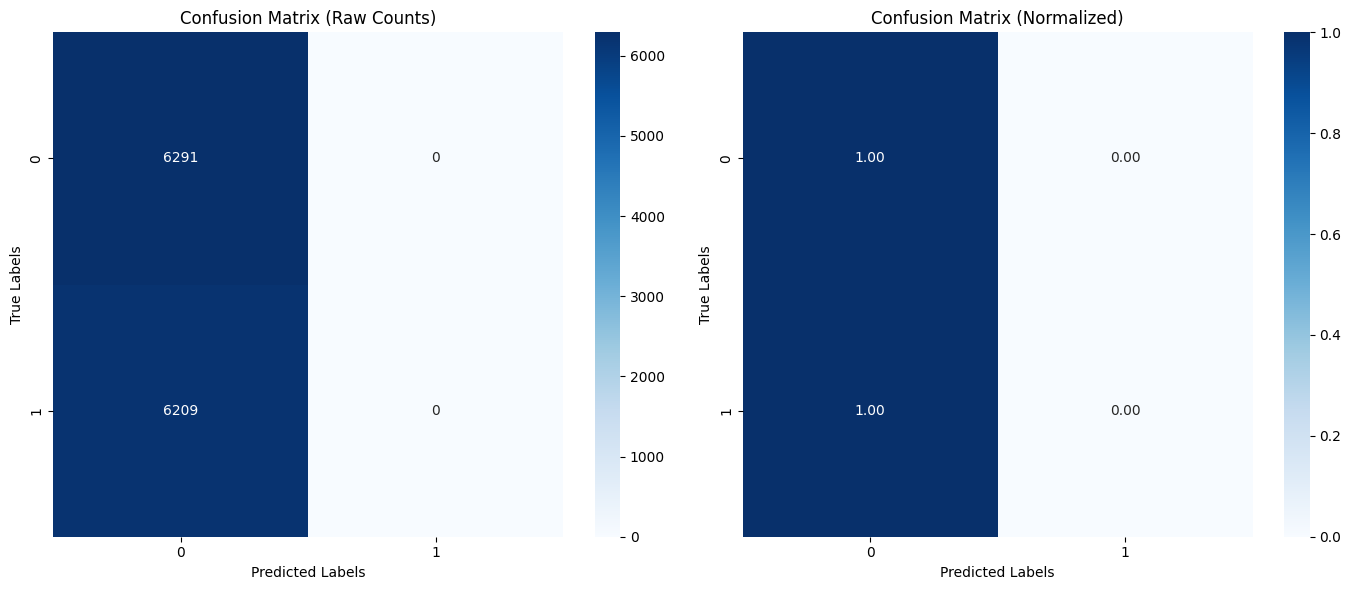

In [47]:
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Normalized confusion matrix
normalized_conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# Plot raw confusion matrix using Seaborn
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(n_classes), yticklabels=range(n_classes))
plt.title("Confusion Matrix (Raw Counts)")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")

# Plot normalized confusion matrix using Seaborn
plt.subplot(1, 2, 2)
sns.heatmap(normalized_conf_matrix, annot=True, fmt='.2f', cmap='Blues', xticklabels=range(n_classes), yticklabels=range(n_classes))
plt.title("Confusion Matrix (Normalized)")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")

plt.tight_layout()
plt.show()

# # Alternatively, display normalized confusion matrix using sklearn
# disp = ConfusionMatrixDisplay(normalized_conf_matrix, display_labels=range(n_classes))
# disp.plot(cmap='Blues', values_format='.2f')
# plt.title("Normalized Confusion Matrix")
# plt.show()


TypeError: '_PrefetchDataset' object is not subscriptable

## GRU (MultiLayer and Bidirectional)

In [50]:
EMBEDDING_DIM=64
model=tf.keras.models.Sequential([
    Input(shape=(SEQUENCE_LENGTH,)),
    Embedding(VOCAB_SIZE,EMBEDDING_DIM),

    Bidirectional(GRU(64,return_sequences=True)),
    Bidirectional(GRU(32)),

    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1,activation='sigmoid'),
])
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ (None, 250, 64)             │         640,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ (None, 250, 128)            │          49,920 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_3 (Bidirectional)      │ (None, 64)                  │          31,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 725,249 (2.77 MB)

 Trainable params: 725,249 (2.77 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
checkpoint_filepath = '/content/drive/MyDrive/nlp/sentiment_analysis/gru.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [51]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [52]:
history=model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
    callbacks=[])

Epoch 1/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 25s 57ms/step - accuracy: 0.5101 - loss: 0.6930 - val_accuracy: 0.5690 - val_loss: 0.6888
Epoch 2/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 40s 54ms/step - accuracy: 0.6364 - loss: 0.6255 - val_accuracy: 0.7995 - val_loss: 0.4338
Epoch 3/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 22s 56ms/step - accuracy: 0.8510 - loss: 0.3553 - val_accuracy: 0.8551 - val_loss: 0.3479
Epoch 4/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 41s 55ms/step - accuracy: 0.9052 - loss: 0.2550 - val_accuracy: 0.8582 - val_loss: 0.3880
Epoch 5/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 44s 64ms/step - accuracy: 0.9247 - loss: 0.2143 - val_accuracy: 0.8574 - val_loss: 0.4092
Epoch 6/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 22s 55ms/step - accuracy: 0.9305 - loss: 0.1957 - val_accuracy: 0.8534 - val_loss: 0.4024
Epoch 7/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 20s 52ms/step - accuracy: 0.9340 - loss: 0.1869 - val_accuracy: 0.8490 - val_loss: 0.4466
Epoch 8/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 21s 54ms/step - accuracy: 0.9468 - loss: 0.1575 - 

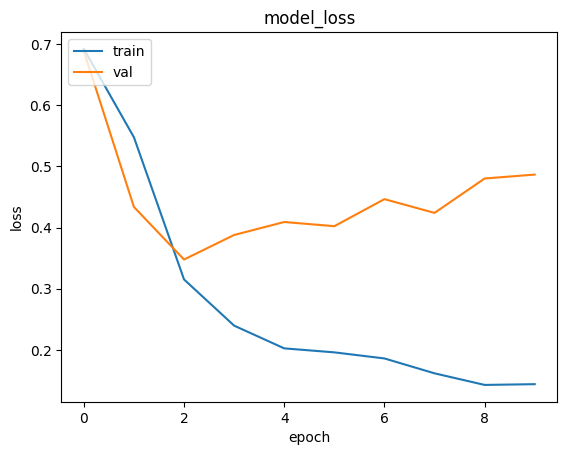

In [53]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

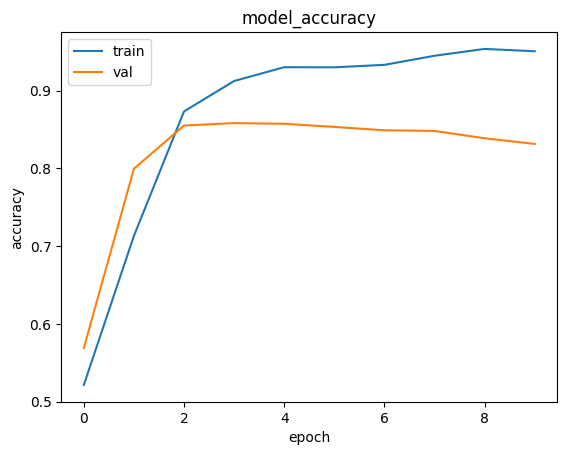

In [54]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model_accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Evaluation

In [55]:
test_dataset=test_ds.map(vectorizer)
test_dataset=test_dataset.batch(BATCH_SIZE)
model.evaluate(test_dataset)

196/196 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.8271 - loss: 0.4987


[0.4919271469116211, 0.8273599743843079]

AUC Score: 0.8726279907239016


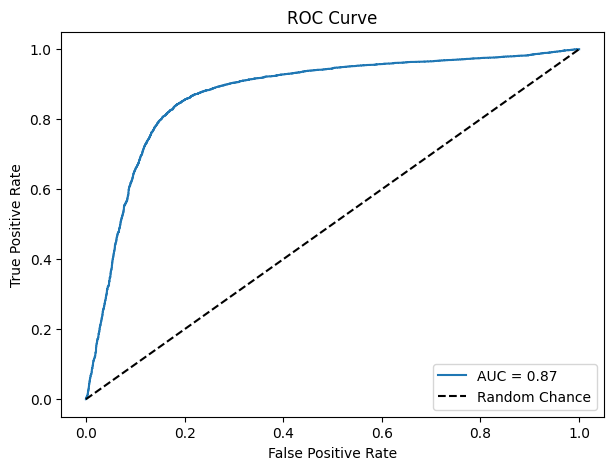

In [57]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Assuming binary classification
y_true_binarized = label_binarize(y_true, classes=[0, 1])[:, 0]
y_pred_probs = np.squeeze(y_pred_probs)  # Convert (num_samples, 1) -> (num_samples,)

auc_score = roc_auc_score(y_true_binarized, y_pred_probs)
fpr, tpr, _ = roc_curve(y_true_binarized, y_pred_probs)

print(f"AUC Score: {auc_score}")

# Plot ROC Curve
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.2f}")
plt.plot([0, 1], [0, 1], 'k--', label="Random Chance")
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()



## Conv1D

In [59]:
EMBEDDING_DIM=300
model=tf.keras.models.Sequential([
    Input(shape=(SEQUENCE_LENGTH,)),
    Embedding(VOCAB_SIZE,EMBEDDING_DIM),

    Conv1D(32, 3, activation='relu',),
    Flatten(),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(1,activation='sigmoid'),
])
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)              │ (None, 250, 300)            │       3,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 248, 32)             │          28,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 7936)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 32)                  │         253,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,282,849 (12.52 MB)

 Trainable params: 3,282,849 (12.52 MB)

 Non-trainable params: 0 (0.00 B)

In [60]:
checkpoint_filepath = '/content/drive/MyDrive/nlp/sentiment_analysis/conv_1d.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

ValueError: The filepath provided must end in `.keras` (Keras model format). Received: filepath=/content/drive/MyDrive/nlp/sentiment_analysis/conv_1d.h5

In [61]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [62]:
history=model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
    callbacks=[])

Epoch 1/10


InvalidArgumentError: Graph execution error:

Detected at node sequential_3_1/flatten_1/Reshape defined at (most recent call last):
<stack traces unavailable>
only one input size may be -1, not both 0 and 1

Stack trace for op definition: 
File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main
File "/usr/lib/python3.10/runpy.py", line 86, in _run_code
File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>
File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance
File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start
File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start
File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever
File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once
File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run
File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 685, in <lambda>
File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 738, in _run_callback
File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 825, in inner
File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run
File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 361, in process_one
File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper
File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell
File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper
File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request
File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper
File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute
File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell
File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell
File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell
File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner
File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async
File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes
File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
File "<ipython-input-62-8c0f91bd5ba6>", line 1, in <cell line: 1>
File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler
File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 320, in fit
File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 121, in one_step_on_iterator
File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 108, in one_step_on_data
File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 51, in train_step
File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler
File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py", line 901, in __call__
File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler
File "/usr/local/lib/python3.10/dist-packages/keras/src/ops/operation.py", line 46, in __call__
File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler
File "/usr/local/lib/python3.10/dist-packages/keras/src/models/sequential.py", line 212, in call
File "/usr/local/lib/python3.10/dist-packages/keras/src/models/functional.py", line 175, in call
File "/usr/local/lib/python3.10/dist-packages/keras/src/ops/function.py", line 171, in _run_through_graph
File "/usr/local/lib/python3.10/dist-packages/keras/src/models/functional.py", line 560, in call
File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler
File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py", line 901, in __call__
File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler
File "/usr/local/lib/python3.10/dist-packages/keras/src/ops/operation.py", line 46, in __call__
File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler
File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py", line 54, in call
File "/usr/local/lib/python3.10/dist-packages/keras/src/ops/numpy.py", line 4440, in reshape
File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/numpy.py", line 1789, in reshape

	 [[{{node sequential_3_1/flatten_1/Reshape}}]]
	tf2xla conversion failed while converting __inference_one_step_on_data_2178788[]. Run with TF_DUMP_GRAPH_PREFIX=/path/to/dump/dir and --vmodule=xla_compiler=2 to obtain a dump of the compiled functions.
	 [[StatefulPartitionedCall]] [Op:__inference_one_step_on_iterator_2178849]

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model_accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Evaluation

In [ ]:
model.load_weights(checkpoint_filepath)

In [ ]:
test_dataset=test_ds.map(vectorizer)
test_dataset=test_dataset.batch(BATCH_SIZE)
model.evaluate(test_dataset)

## Pretrained Word2Vec[Gensim]

In [ ]:
word2vec=api.load('word2vec-google-news-300')

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [ ]:
word2vec.vectors.shape

(3000000, 300)

In [ ]:
#print(word2vec.vocab)
len(word2vec['The'])

300

In [ ]:
word2vec.most_similar('Man')

[('Woman', 0.693934440612793),
 ('Boy', 0.5896924734115601),
 ('Girl', 0.584598958492279),
 ('Suspect', 0.5577560067176819),
 ('Couple', 0.5528684854507446),
 ('man', 0.5316052436828613),
 ('Robber', 0.5315312147140503),
 ('Teenager', 0.5161929130554199),
 ('depicts_Michelangelo_Creation', 0.5148171782493591),
 ('Policeman', 0.5136396288871765)]

In [ ]:
pretrained_embeddings=[]

In [ ]:
def first_caps(word):
  return word[0].upper()+word[1:]

In [ ]:
vectorize_layer.get_vocabulary()[2]

'the'

In [ ]:
#first_caps(vectorize_layer.get_vocabulary()[2])

'The'

In [ ]:
pretrained_embeddings=[]

In [ ]:
len(vectorize_layer.get_vocabulary())

10000

In [ ]:
for i in range(len(vectorize_layer.get_vocabulary())):
  try:
    pretrained_embeddings.append(word2vec[vectorize_layer.get_vocabulary()[i]])
  except:
    print(vectorize_layer.get_vocabulary()[i])
    try:
      pretrained_embeddings.append(word2vec[first_caps(vectorize_layer.get_vocabulary()[i])])
      print('toupper')
    except:
      print('nosolution')
      pretrained_embeddings.append(random.normal(loc=0, scale=1, size=(EMBEDDING_DIM)))#reloaded_word_vectors[vectorize_layer.get_vocabulary()[i]])
  if i%1000==0:
    print('iis====================================',i)

In [ ]:
pretrained_embeddings_array=np.array(pretrained_embeddings)
print(pretrained_embeddings_array.shape)

(10000, 300)


In [ ]:
#np.save('/content/drive/MyDrive/nlp/sentiment_analysis/pretrained_embeddings',pretrained_embeddings_array)

In [ ]:
pretrained_embeddings_array=np.load('/content/drive/MyDrive/nlp/sentiment_analysis/pretrained_embeddings.npy')

In [ ]:
pretrained_embeddings_array.shape

(10000, 300)

In [ ]:
EMBEDDING_DIM=300
model=tf.keras.models.Sequential([
    Input(shape=(SEQUENCE_LENGTH,)),
    Embedding(
        VOCAB_SIZE,
        EMBEDDING_DIM,
        embeddings_initializer=tf.keras.initializers.Constant(pretrained_embeddings_array),
        trainable=True,
    ),

    Conv1D(32, 3, activation='relu',),
    Flatten(),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(1,activation='sigmoid'),
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 250, 300)          3000000   
                                                                 
 conv1d_1 (Conv1D)           (None, 248, 32)           28832     
                                                                 
 flatten_1 (Flatten)         (None, 7936)              0         
                                                                 
 dense_2 (Dense)             (None, 32)                253984    
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 3,282,849
Trainable params: 3,282,849
No

In [ ]:
checkpoint_filepath = '/content/drive/MyDrive/nlp/sentiment_analysis/conv_1d_word2vec.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
history=model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
    callbacks=[model_checkpoint_callback])

Epoch 1/50
25/25 [==============================] - 10s 372ms/step - loss: 0.7380 - accuracy: 0.5144 - val_loss: 0.6953 - val_accuracy: 0.5048
Epoch 2/50
25/25 [==============================] - 6s 251ms/step - loss: 0.6849 - accuracy: 0.5337 - val_loss: 0.6952 - val_accuracy: 0.5051
Epoch 3/50
25/25 [==============================] - 6s 259ms/step - loss: 0.6765 - accuracy: 0.5619 - val_loss: 0.6971 - val_accuracy: 0.5081
Epoch 4/50
25/25 [==============================] - 6s 251ms/step - loss: 0.6665 - accuracy: 0.5894 - val_loss: 0.6961 - val_accuracy: 0.5101
Epoch 5/50
25/25 [==============================] - 4s 167ms/step - loss: 0.6508 - accuracy: 0.6156 - val_loss: 0.6974 - val_accuracy: 0.5054
Epoch 6/50
25/25 [==============================] - 6s 250ms/step - loss: 0.6379 - accuracy: 0.6244 - val_loss: 0.6993 - val_accuracy: 0.5128
Epoch 7/50
25/25 [==============================] - 4s 176ms/step - loss: 0.6204 - accuracy: 0.6488 - val_loss: 0.7035 - val_accuracy: 0.5092
Epoch

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-28-bc8ba518b435>", line 5, in <module>
    callbacks=[model_checkpoint_callback])
  File "/usr/local/lib/python3.7/dist-packages/keras/utils/traceback_utils.py", line 64, in error_handler
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/keras/engine/training.py", line 1431, in fit
    _use_cached_eval_dataset=True)
  File "/usr/local/lib/python3.7/dist-packages/keras/utils/traceback_utils.py", line 64, in error_handler
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/keras/engine/training.py", line 1716, in evaluate
    tmp_logs = self.test_function(iterator)
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/traceback_utils.py", line 150, in error_handler
    return fn(*args, **kwargs)
  File "/u

KeyboardInterrupt: ignored

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model_accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Evaluation

In [ ]:
model.load_weights(checkpoint_filepath)

In [ ]:
test_dataset=test_ds.map(vectorizer)
test_dataset=test_dataset.batch(BATCH_SIZE)
model.evaluate(test_dataset)

# Testing

In [ ]:
# test_pos="this movie looks very interesting, i love the fact that the actors do a great job in showing how people lived in the 18th century, which wasn't very good at all. But atleast this movie recreates this scenes! "
# test_neg="very good start, but movie started becoming boring at some point and unfortunately i didn't feel like this was properly produced as there was too much background noise, and the actors didn't look motivated at all "

In [63]:
test_data=tf.data.Dataset.from_tensor_slices([["this movie looks very interesting, i love the fact that the actors do a great job in showing how people lived in the 18th century, which wasn't very good at all. But atleast this movie recreates this scenes! "],
                                              ["very good start, but movie started becoming interesting at some point and fortunately at some point it started becoming much more fun, though there was too much background noise, so in all i liked this movie "],])


In [64]:
def vectorizer_test(review):
    return vectorize_layer(review)
test_dataset=test_data.map(vectorizer_test)

In [65]:
model.predict(test_dataset)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


array([[0.50223255],
       [0.501282  ]], dtype=float32)

## Inference Ready Testing

In [66]:
inputs = Input(shape=(1,), dtype="string")
vectorized_inputs=vectorize_layer(inputs)
outputs = model(vectorized_inputs)
inference_ready_model = tf.keras.Model(inputs, outputs)
inference_ready_model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 1)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ text_vectorization                   │ (None, 250)                 │               0 │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_3 (Sequential)            │ (None, 1)                   │       3,282,849 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,282,849 (12.52 MB)

 Trainable params: 3,282,849 (12.52 MB)

 Non-trainable params: 0 (0.00 B)

In [67]:
inference_ready_model.predict(["this movie looks very interesting, i love the fact that the actors do a great job in showing how people lived in the 18th century, which wasn't very good at all. But atleast this movie recreates this scenes! ",
                               "very good start, but movie started becoming interesting at some point and fortunately at some point it started becoming much more fun, though there was too much background noise, so in all i liked this movie "])

ValueError: Unrecognized data type: x=["this movie looks very interesting, i love the fact that the actors do a great job in showing how people lived in the 18th century, which wasn't very good at all. But atleast this movie recreates this scenes! ", 'very good start, but movie started becoming interesting at some point and fortunately at some point it started becoming much more fun, though there was too much background noise, so in all i liked this movie '] (of type <class 'list'>)

# Visualize Embeddings

In [68]:
EMBEDDING_DIM=300
model=tf.keras.models.Sequential([
    Input(shape=(SEQUENCE_LENGTH,)),
    Embedding(VOCAB_SIZE,EMBEDDING_DIM),

    Conv1D(32, 3, activation='relu',),
    Flatten(),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(1,activation='sigmoid'),
])
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)              │ (None, 250, 300)            │       3,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 248, 32)             │          28,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 7936)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 32)                  │         253,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,282,849 (12.52 MB)

 Trainable params: 3,282,849 (12.52 MB)

 Non-trainable params: 0 (0.00 B)

In [69]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [70]:
log_dir='logs/imdb/fit/'+datetime.datetime.now().strftime("%Y%m%d-%H%M%S")+'/'

In [71]:
tensorboard_callback=tf.keras.callbacks.TensorBoard(log_dir,histogram_freq=1)

In [73]:
history=model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=5,
    callbacks=[])

Epoch 1/5


InvalidArgumentError: Graph execution error:

Detected at node sequential_4_1/flatten_1_1/Reshape defined at (most recent call last):
<stack traces unavailable>
only one input size may be -1, not both 0 and 1

Stack trace for op definition: 
File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main
File "/usr/lib/python3.10/runpy.py", line 86, in _run_code
File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>
File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance
File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start
File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start
File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever
File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once
File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run
File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 685, in <lambda>
File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 738, in _run_callback
File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 825, in inner
File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run
File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 361, in process_one
File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper
File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell
File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper
File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request
File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper
File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute
File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell
File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell
File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell
File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner
File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async
File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes
File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
File "<ipython-input-72-8ac29987973a>", line 1, in <cell line: 1>
File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler
File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 320, in fit
File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 121, in one_step_on_iterator
File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 108, in one_step_on_data
File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 51, in train_step
File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler
File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py", line 901, in __call__
File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler
File "/usr/local/lib/python3.10/dist-packages/keras/src/ops/operation.py", line 46, in __call__
File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler
File "/usr/local/lib/python3.10/dist-packages/keras/src/models/sequential.py", line 212, in call
File "/usr/local/lib/python3.10/dist-packages/keras/src/models/functional.py", line 175, in call
File "/usr/local/lib/python3.10/dist-packages/keras/src/ops/function.py", line 171, in _run_through_graph
File "/usr/local/lib/python3.10/dist-packages/keras/src/models/functional.py", line 560, in call
File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler
File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py", line 901, in __call__
File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler
File "/usr/local/lib/python3.10/dist-packages/keras/src/ops/operation.py", line 46, in __call__
File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler
File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py", line 54, in call
File "/usr/local/lib/python3.10/dist-packages/keras/src/ops/numpy.py", line 4440, in reshape
File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/numpy.py", line 1789, in reshape

	 [[{{node sequential_4_1/flatten_1_1/Reshape}}]]
	tf2xla conversion failed while converting __inference_one_step_on_data_2180687[]. Run with TF_DUMP_GRAPH_PREFIX=/path/to/dump/dir and --vmodule=xla_compiler=2 to obtain a dump of the compiled functions.
	 [[StatefulPartitionedCall]] [Op:__inference_one_step_on_iterator_2180748]

In [ ]:
with open(os.path.join(log_dir,'metadata.tsv'),"w",encoding="utf-8") as f:
  for i in range(VOCAB_SIZE):
    f.write("{} {}\n".format(i,vectorize_layer.get_vocabulary()[i]))

In [ ]:
embedding_weights=tf.Variable(model.layers[0].get_weights()[0])
print(embedding_weights.shape)

(10000, 300)


In [ ]:
checkpoint=tf.train.Checkpoint(embedding=embedding_weights)
checkpoint.save(os.path.join(log_dir,"embedding.ckpt"))

config=projector.ProjectorConfig()
embedding=config.embeddings.add()

In [ ]:
embedding.metadata_path='metadata.tsv'
projector.visualize_embeddings(log_dir,config)

In [ ]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
%tensorboard --logdir logs/imdb/fit/